This is a version of the algo found in: https://github.com/CL2-UWaterloo/Raceline-Optimization/blob/master/map_converter.ipynb

In [16]:
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import yaml
import scipy
from scipy.ndimage import distance_transform_edt
from PIL import Image
import os

We need to import the map and convert it into an array. Then we want to transform it by the Euclidian Distance, and skeletonize it to get the centerline. 

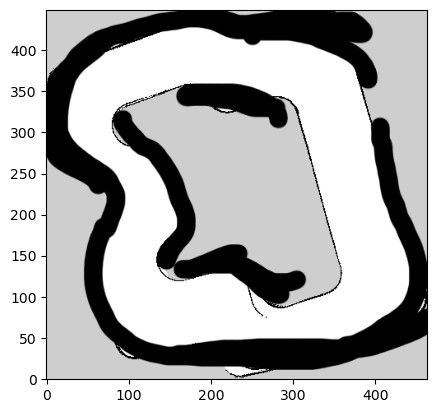

In [17]:
og_map_pgm_arr = np.array(Image.open("maps/ens_race3.pgm").transpose(Image.FLIP_TOP_BOTTOM),dtype=np.float64)

plt.imshow(og_map_pgm_arr, cmap='gray', origin='lower')

We now want to binarize the image. Everything under a threshold becomes black, everything above becomes white. 

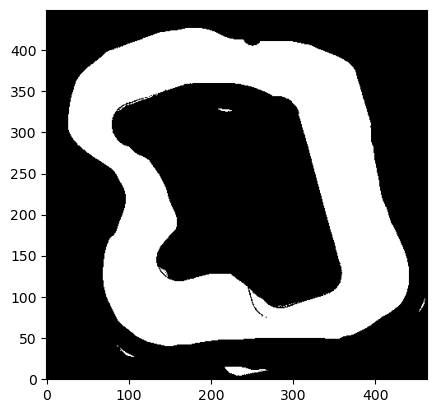

In [18]:
binarized_map = np.copy(og_map_pgm_arr)
binarized_map[binarized_map <= 210] = 0
binarized_map[binarized_map > 210] = 1

map_height = binarized_map.shape[0]


plt.imshow(binarized_map, cmap='gray', origin='lower')

The image has some salt and pepper noise. Median filtering to remove it?

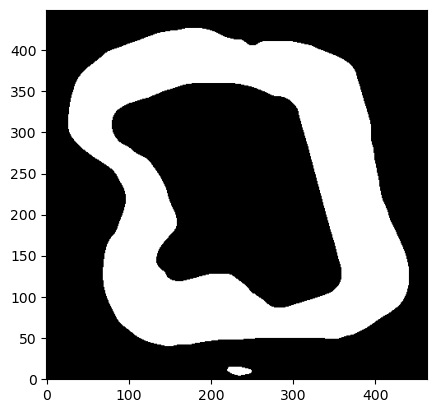

In [19]:
# denoised_binarized_map = scipy.ndimage.median_filter(binarized_map, 20, mode='constant')
denoised_binarized_map = scipy.signal.medfilt2d(binarized_map, 9)
denoised_binarized_map = scipy.signal.medfilt2d(binarized_map, 9)

plt.figure()
plt.imshow(denoised_binarized_map, cmap='gray', origin='lower')

Compute the Euclidian Distance Transform (EDT)

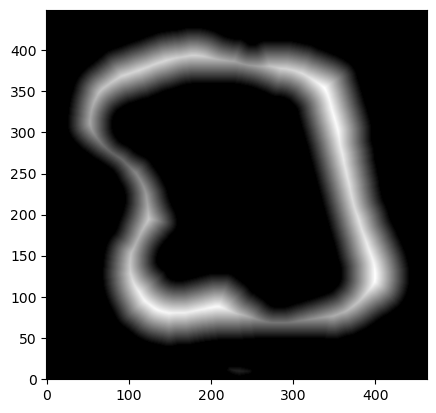

In [20]:
edt_map = scipy.ndimage.distance_transform_edt(denoised_binarized_map)
plt.imshow(edt_map, cmap='gray', origin='lower')

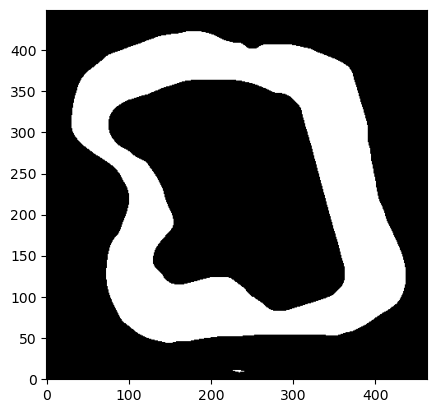

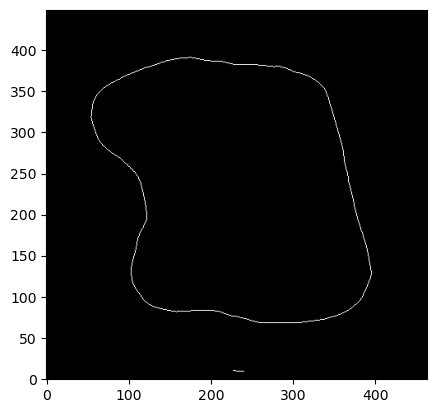

In [21]:
centers = edt_map > 0.1 * edt_map.max()

plt.imshow(centers, cmap='gray', origin='lower')

plt.figure()

centerline = skeletonize(centers)
plt.imshow(centerline, cmap='gray', origin='lower')

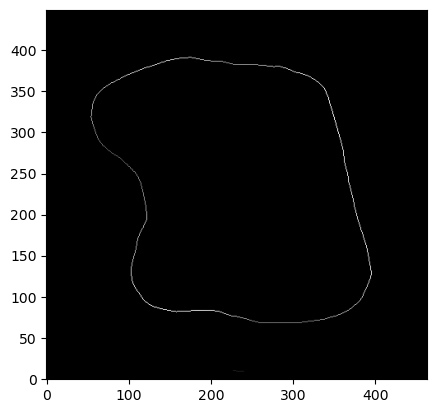

In [22]:
#We filter the EDT by the skeletonized map to get the values from the EDT (ie. the distance to the edges of the track)


centerline_dist = np.where(centerline, edt_map, 0)
plt.imshow(centerline_dist, origin='lower', cmap='gray')

In [28]:
LEFT_START_Y = map_height // 2 - 120
NON_EDGE = 0.0
# Use DFS to  the outer edge
left_start_y = 300
left_start_x = 30
while (not centerline_dist[left_start_y][left_start_x]): 
	left_start_x += 1

print(f"Starting position for left edge: {left_start_x} {left_start_y}")

Starting position for left edge: 60 300


In [29]:
# Run DFS
import sys
sys.setrecursionlimit(20000)

visited = {}
centerline_points = []
track_widths = []
DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
# If you want the other direction first
# DIRECTIONS = [(0, -1), (-1, 0),  (0, 1), (1, 0), (-1, 1), (-1, -1), (1, 1), (1, -1) ]
# DIRECTIONS = [(-1, 0),(0, -1),  (1, 0), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1) ]


starting_point = (left_start_x, left_start_y)

def dfs(point):
	if (point in visited): return
	visited[point] = True
	centerline_points.append(np.array(point))
	track_widths.append(np.array([centerline_dist[point[1]][point[0]], centerline_dist[point[1]][point[0]]]))

	for direction in DIRECTIONS:
		if (centerline_dist[point[1] + direction[1]][point[0] + direction[0]] != NON_EDGE and (point[0] + direction[0], point[1] + direction[1]) not in visited):
			dfs((point[0] + direction[0], point[1] + direction[1]))

dfs(starting_point)

(1057, 2)


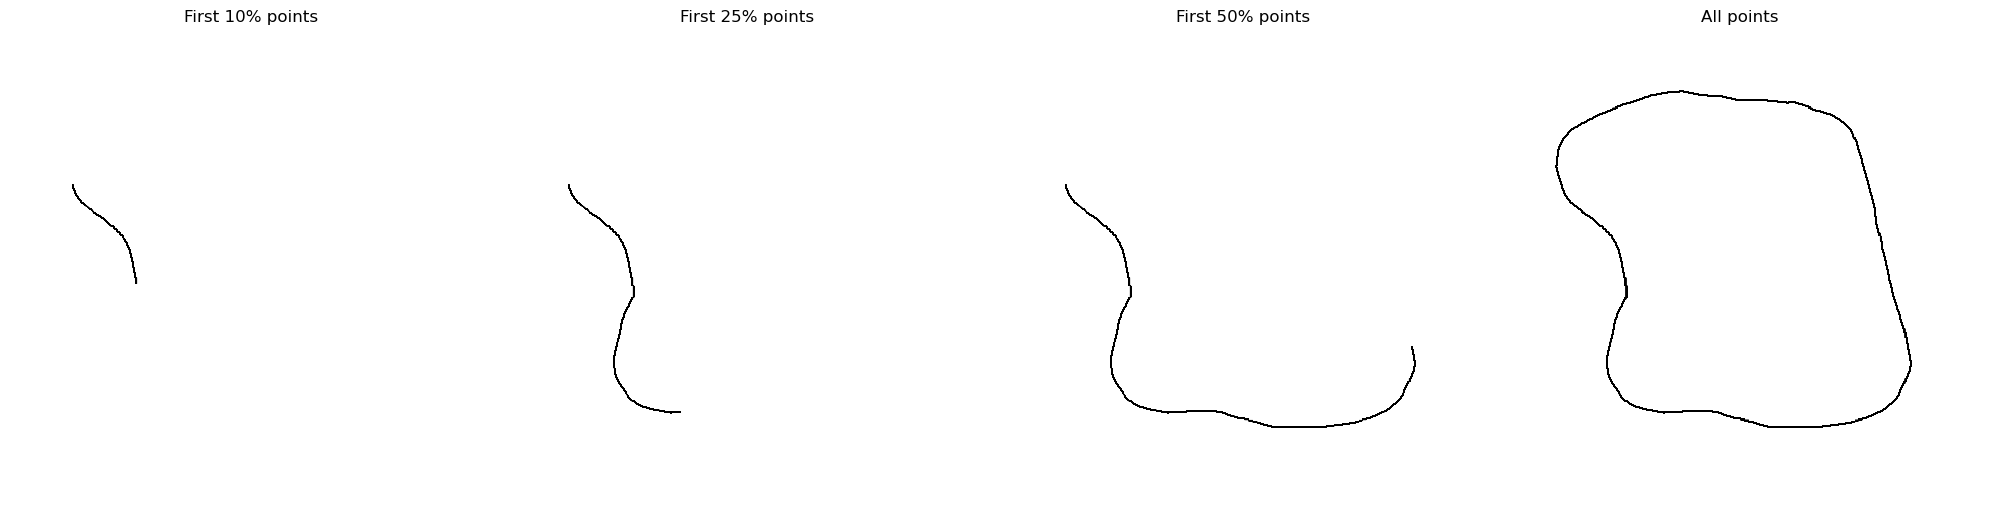

In [30]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

centerline_img = np.zeros(binarized_map.shape)
for x,y in centerline_points[:len(centerline_points)//10]:
	centerline_img[y][x] = 255
ax1.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax1.set_title("First 10% points")

centerline_img = np.zeros(binarized_map.shape)
for x,y in centerline_points[:len(centerline_points)//4]:
	centerline_img[y][x] = 255
ax2.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax2.set_title("First 25% points")

centerline_img = np.zeros(binarized_map.shape)
for x,y in centerline_points[:int(len(centerline_points)//2)]:
	centerline_img[y][x] = 255
ax3.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax3.set_title("First 50% points")


print(np.shape(centerline_points))


centerline_img = np.zeros(binarized_map.shape)
for x,y in centerline_points:
	centerline_img[y][x] = 1000
ax4.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax4.set_title("All points")
fig.tight_layout()

In [31]:
track_widths_np = np.array(track_widths[:int(len(centerline_points)/1.004)])
waypoints = np.array(centerline_points[:int(len(centerline_points)/1.004)])
print(f"Track widths shape: {track_widths_np.shape}, waypoints shape: {waypoints.shape}")

Track widths shape: (1052, 2), waypoints shape: (1052, 2)


In [32]:
# Merge track with waypoints
data = np.concatenate((waypoints, track_widths_np), axis=1)
data.shape

print(waypoints)

[[ 60 300]
 [ 60 299]
 [ 60 298]
 ...
 [ 57 308]
 [ 57 307]
 [ 58 306]]


In [33]:
# load map yaml
with open("maps/ens_race3.yaml", 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
# orig_s = np.sin(origin[2])
# orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = np.copy(data)

print(transformed_data)

transformed_data *= map_resolution

print(transformed_data)

print("origin: ", origin)

transformed_data += np.array([orig_x, orig_y, 0, 0])

print(transformed_data)


# Safety margin

TRACK_WIDTH_MARGIN = 0.1
transformed_data -= np.array([0, 0, TRACK_WIDTH_MARGIN, TRACK_WIDTH_MARGIN])

[[ 60.         300.          20.39607805  20.39607805]
 [ 60.         299.          20.61552813  20.61552813]
 [ 60.         298.          20.88061302  20.88061302]
 ...
 [ 57.         308.          23.          23.        ]
 [ 57.         307.          23.          23.        ]
 [ 58.         306.          22.          22.        ]]
[[1.2        6.         0.40792156 0.40792156]
 [1.2        5.98       0.41231056 0.41231056]
 [1.2        5.96       0.41761226 0.41761226]
 ...
 [1.14       6.16       0.46       0.46      ]
 [1.14       6.14       0.46       0.46      ]
 [1.16       6.12       0.44       0.44      ]]
origin:  [-3.951799, -1.433864, 0.0]
[[-2.751799    4.566136    0.40792156  0.40792156]
 [-2.751799    4.546136    0.41231056  0.41231056]
 [-2.751799    4.526136    0.41761226  0.41761226]
 ...
 [-2.811799    4.726136    0.46        0.46      ]
 [-2.811799    4.706136    0.46        0.46      ]
 [-2.791799    4.686136    0.44        0.44      ]]


In [183]:
transformed_data = transformed_data[::4]

In [34]:
with open(f"ens_race3.csv", 'wb') as fh:
    np.savetxt(fh, transformed_data, fmt='%0.4f', delimiter=',', header='x_m,y_m,w_tr_right_m,w_tr_left_m')